CS7140

Rajesh Sakhamuru

Zhiyu Chen

# LSTM Model for mRNA Degredation Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def oneHotEncode(rowDict):
    """
    One-hot encode a single sample's sequence data
    """
    categories = ['ACGU', '.()', 'BEHIMSX']

    seq = rowDict['sequence']
    oneHotSeq = np.zeros((len(seq),len(categories[0])))
    for i, char in enumerate(seq):
        oneHotSeq[i, categories[0].index(char)] = 1

    struc = rowDict['structure']
    oneHotStruc = np.zeros((len(struc),len(categories[1])))
    for i, char in enumerate(struc):
        oneHotStruc[i, categories[1].index(char)] = 1

    loop = rowDict['predicted_loop_type']
    oneHotLoop = np.zeros((len(loop),len(categories[2])))
    for i, char in enumerate(loop):
        oneHotLoop[i, categories[2].index(char)] = 1

    return np.hstack([oneHotSeq, oneHotStruc, oneHotLoop])

In [ ]:
def loadTrainData(filePath):
    """
    Loads training and target feature data from the test.json sequence data.
    One-hot encodes the data in the process.
    """
    oneHotTrain = None
    targetTrain = None
    with open(filePath, 'r') as data:
        for row in data:
            rowDict = json.loads(row)
            # Removes noisy training samples where SN_filter == 0 (Signal/Noise filter)
            if rowDict['SN_filter'] != 1:
                continue
            oneHotRow = oneHotEncode(rowDict)
            targets = np.stack([rowDict['reactivity'], rowDict['deg_Mg_pH10'],rowDict['deg_pH10'], rowDict['deg_Mg_50C'], rowDict['deg_50C']], axis=1)

            if oneHotTrain is None:
                oneHotTrain = np.array([oneHotRow])
                targetTrain = np.array([targets])
                continue

            oneHotTrain = np.append(oneHotTrain, [oneHotRow], axis=0)
            targetTrain = np.append(targetTrain, [targets], axis=0)

    return torch.tensor(oneHotTrain).to(torch.int64).to(device), torch.tensor(targetTrain).to(torch.float).to(device)

In [ ]:
def loadTestData(filePath):
    """
    Loads the 107 length and 130 length sequence data for seperate competition testing  
    One-hot encodes the data in the process.
    We do not have target values for this data
    """
    oneHotTest_107 = None
    oneHotTest_130 = None

    with open(filePath, 'r') as data:
        for row in data:
            rowDict = json.loads(row)
            oneHotRow = oneHotEncode(rowDict)

            if rowDict['seq_length'] == 107 and oneHotTest_107 is None:
                oneHotTest_107 = np.array([oneHotRow])
                continue
            elif rowDict['seq_length'] == 130 and oneHotTest_130 is None:
                oneHotTest_130 = np.array([oneHotRow])
                continue

            if rowDict['seq_length'] == 107:
                oneHotTest_107 = np.append(oneHotTest_107, [oneHotRow], axis=0)
            else:
                oneHotTest_130 = np.append(oneHotTest_130, [oneHotRow], axis=0)

    oneHotTest_107 = torch.tensor(oneHotTest_107).to(torch.int64).to(device)
    oneHotTest_130 = torch.tensor(oneHotTest_130).to(torch.int64).to(device)

    return oneHotTest_107, oneHotTest_130

In [ ]:
class LSTMBiDirecModel(nn.Module):
    """
    Bi-directional LSTM model which takes 14-features 1-hot encoded at each timestep
    """
    def __init__(self, seqLen=107, predLen=68, hidLayers=3, embedDim=100, hidDim=128):
        super(LSTMBiDirecModel, self).__init__()
        self.predLen=predLen
        self.embedding=nn.Embedding(14, embedDim)
        self.lstmLayers = nn.LSTM(input_size=embedDim*14,
                                  hidden_size=hidDim,
                                  num_layers=hidLayers,
                                  dropout=0.5,
                                  bidirectional=True,
                                  batch_first=True)
        self.linear = nn.Linear(hidDim*2, 5)

    def forward(self,X):
        embedLayer = self.embedding(X)
        reshapedEmbedding = torch.reshape(embedLayer,(-1, embedLayer.shape[1], embedLayer.shape[2]*embedLayer.shape[3]))
        output, _ = self.lstmLayers(reshapedEmbedding)
        
        # Only make predictions for verifiable target values when training
        hiddenVals = output[:,:self.predLen,:]
        return self.linear(hiddenVals)

In [ ]:
def calcLoss(X, Y, model, optimizer=None, isTrain=True):
    """
    Calculate and backpropogate the loss based on the MSE loss function
    """
    model.train(isTrain)
    mseLoss = nn.MSELoss()
    predictions = model(X)
    loss = mseLoss(predictions, Y)
    if isTrain:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

In [ ]:
def trainTestLSTMModel(oneHotTrain, targetTrain, test107DataLoader, test130DataLoader, lr=0.001, epochs=100, weightsPath='drive/MyDrive/Colab Notebooks/CS7140 Final Project/CS7140Models/covidLSTMModel.pth'):
    """
    Run 4-fold cross validation on the dataset to train it, then make a weighted average of the predictions and return the 
    predicitons and model history. Also plots training vs validation loss per epoch.
    """
    histories=[]
    test107Preds = np.zeros((oneHotTest_107.shape[0], 107, 5))
    test130Preds = np.zeros((oneHotTest_130.shape[0], 130, 5))

    # 4-fold validation and take the average predictions of the 4 folds for final submission
    kfold=KFold(n_splits=4, shuffle=True, random_state=42)
    for foldNum, (trainIdx, valIdx) in enumerate(kfold.split(oneHotTrain)):
        trainDataLoader = DataLoader(TensorDataset(oneHotTrain[trainIdx], targetTrain[trainIdx]), shuffle=True, batch_size=128)
        valDataLoader = DataLoader(TensorDataset(oneHotTrain[valIdx], targetTrain[valIdx]), shuffle=False, batch_size=128)
        
        lstmModel = LSTMBiDirecModel().to(device)
        optimizer = torch.optim.Adam(lstmModel.parameters(), lr=lr)
        
        trainLossList = []
        valLossList = []

        for epoch in range(epochs):
            trainLoss = []
            valLoss = []
            for X, Y in trainDataLoader:
                trainLoss.append(calcLoss(X,Y,lstmModel, optimizer=optimizer, isTrain=True))
            for X, Y in valDataLoader:
                valLoss.append(calcLoss(X,Y,lstmModel, optimizer=optimizer, isTrain=False))
        
            trainLossList.append(sum(trainLoss)/len(trainLoss))
            valLossList.append(sum(valLoss)/len(valLoss))
    
        torch.save(lstmModel.state_dict(), weightsPath)
        lstmWeightsState = lstmModel.state_dict()
        del lstmModel

        histories.append({'trainLoss':trainLossList, 'valLoss': valLossList})
        
        if foldNum == 0:
            plt.plot(trainLossList,'b-',label='train')
            plt.plot(valLossList,'g-',label='val')
        else:
            plt.plot(trainLossList,'b-')
            plt.plot(valLossList,'g-')
        
        # load weights into model for length 107 sequences and make predictions
        lstmTest107Model = LSTMBiDirecModel(seqLen=107,predLen=107).to(device)
        lstmTest107Model.load_state_dict(lstmWeightsState)
        # turn off dropout during evaluation
        lstmTest107Model.eval()
        predictions107 = np.ndarray((0,107,5))
        for testData in test107DataLoader:
            testData = testData[0]
            pred107 = lstmTest107Model(testData)
            pred107 = pred107.cpu().detach().numpy()
            predictions107 = np.concatenate([predictions107, pred107], axis=0)
        test107Preds += predictions107/4
        
        # load weights into model for length 130 sequences and make predictions
        lstmTest130Model = LSTMBiDirecModel(seqLen=130,predLen=130).to(device)
        lstmTest130Model.load_state_dict(lstmWeightsState)
        # turn off dropout during evaluation
        lstmTest130Model.eval()
        predictions130 = np.ndarray((0,130,5))
        for testData in test130DataLoader:
            testData = testData[0]
            pred130 = lstmTest130Model(testData)
            pred130 = pred130.cpu().detach().numpy()
            predictions130 = np.concatenate([predictions130, pred130], axis=0)
        test130Preds += predictions130/4

        print("Fold:",foldNum,", ValidationLoss:",valLossList[-1])

        del lstmTest107Model, lstmTest130Model    
    
    plt.legend(loc='best')
    plt.show()

    return test107Preds, test130Preds, histories

In [ ]:
dataFolder = "drive/MyDrive/Colab Notebooks/CS7140 Final Project/stanford-covid/"
testPath = dataFolder + "test.json"
trainPath = dataFolder + "train.json"

In [ ]:
oneHotTrain, targetTrain = loadTrainData(trainPath)

In [ ]:
# (samples, timesteps, features)
print('Input Shape: ', oneHotTrain.shape)
# Only the first 68 steps in the nucleotide sequence are scored in the training data
print('Output Shape:', targetTrain.shape)

Input Shape:  torch.Size([1589, 107, 14])
Output Shape: torch.Size([1589, 68, 5])


In [ ]:
oneHotTest_107, oneHotTest_130 = loadTestData(testPath)

test107DataLoader = DataLoader(TensorDataset(oneHotTest_107), shuffle=False, batch_size=128)
test130DataLoader = DataLoader(TensorDataset(oneHotTest_130), shuffle=False, batch_size=128)

4-fold cross validation for training LSTM model followed by validation

Fold: 0 , ValidationLoss: 0.05738950241357088
Fold: 1 , ValidationLoss: 0.05703344661742449
Fold: 2 , ValidationLoss: 0.05575762316584587
Fold: 3 , ValidationLoss: 0.05715477094054222


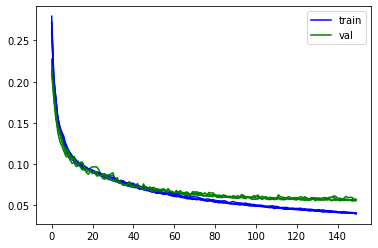

In [ ]:
test107Preds, test130Preds, histories = trainTestLSTMModel(oneHotTrain, targetTrain, test107DataLoader, test130DataLoader, lr=0.001, epochs=150)

####Load predictions to a single dataframe and save to file:

In [ ]:
# print settings for pandas dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

sampleSubmPath = dataFolder + "sample_submission.csv"
submissionDF = pd.read_csv(sampleSubmPath, index_col='id_seqpos')

with open(testPath, 'r') as testdata:
    idx107 = 0
    idx130 = 0
    i = 0
    for row in testdata:
        rowDict = json.loads(row)
        if rowDict['seq_length'] == 107:
            for x in range(107):
                submissionDF.iloc[i] = {'reactivity': test107Preds[idx107][x][0],
                                        'deg_Mg_pH10': test107Preds[idx107][x][1],
                                        'deg_pH10': test107Preds[idx107][x][2],
                                        'deg_Mg_50C': test107Preds[idx107][x][3],
                                        'deg_50C':test107Preds[idx107][x][4]}
                i += 1
            idx107 += 1
        elif rowDict['seq_length'] == 130:
            for x in range(130):
                submissionDF.iloc[i] = {'reactivity': test130Preds[idx130][x][0],
                                        'deg_Mg_pH10': test130Preds[idx130][x][1],
                                        'deg_pH10': test130Preds[idx130][x][2],
                                        'deg_Mg_50C': test130Preds[idx130][x][3],
                                        'deg_50C':test130Preds[idx130][x][4]}
                i += 1
            idx130 += 1
        
print(submissionDF)

                  reactivity  deg_Mg_pH10  deg_pH10  deg_Mg_50C   deg_50C
id_seqpos                                                                
id_00073f8be_0      0.821078     0.728492  2.003676    0.578384  0.705543
id_00073f8be_1      2.798777     3.417343  4.556281    3.482692  2.908738
id_00073f8be_2      1.479272     0.463335  0.599484    0.537763  0.619859
id_00073f8be_3      1.394358     1.272250  1.375535    1.804477  1.557674
id_00073f8be_4      0.911653     0.589520  0.697830    0.860919  0.888720
...                      ...          ...       ...         ...       ...
id_ffda94f24_125    0.275490     0.494338  0.481369    0.637903  0.376113
id_ffda94f24_126    0.258295     0.442905  0.665872    0.630435  0.600253
id_ffda94f24_127    0.522550     0.151904  0.179435    0.281420  0.387942
id_ffda94f24_128    0.239959     0.204538  0.109346    0.314485  0.199139
id_ffda94f24_129    0.056335     0.165746  0.170848    0.299136  0.213675

[457953 rows x 5 columns]


In [ ]:
submissionDF.to_csv(dataFolder+'LSTMSubmission.csv')

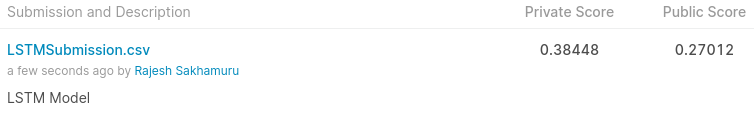

This submission would rank 1236 out of 1636 total submissions to the actual competition. LSTM made predictions where much better than CNN because it is more suited to sequence data, but the results were still not very competitive compared to the best solutions. One advantage this model has over our CNN model is that it ignored any training data with a high noise-to-signal ratio which eliminated noisy training data before training the LSTM model. 

The model did end up in a position which would be 251 positions on the leaderboard better, but the majority of final submissions for the competition were still better. The reason for this is most likely to be because of the best scores having extensive feature engineering, wheras for this submission we had no additional features generated to augment the training/test data other than what was directly given. Most of these submissions also used a blended model and ensembling of 10 or more different models, with the #1 ranked submission using over 50+ models blended to make each prediction.